# Import Packages

In [1]:
from custom_functions import *
sns.set_style('darkgrid')

from wordcloud import WordCloud, STOPWORDS
import matplotlib.colors as mcolors

import nltk
# nltk.download('wordnet')
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
import string
from nltk import word_tokenize, FreqDist
from nltk.sentiment.vader import SentimentIntensityAnalyzer

from gensim.corpora import Dictionary
from gensim.models import Word2Vec

import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_text as text
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.metrics import BinaryAccuracy, Recall, AUC
tf.get_logger().setLevel('ERROR')

from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer, TfidfTransformer
from sklearn.metrics import accuracy_score, f1_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.experimental import enable_hist_gradient_boosting
from sklearn.ensemble import RandomForestClassifier, HistGradientBoostingClassifier
from sklearn.naive_bayes import MultinomialNB
from xgboost import XGBClassifier

### Load in Pickeled DataFrame

In [2]:
tweets = pd.read_pickle('data/pickle_jar/cleaned2.pkl')
denier_sup = pd.read_pickle('data/pickle_jar/denier_sup.pkl')

## Explore Data

In [3]:
# verify import
tweets.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1970258 entries, 0 to 1970257
Data columns (total 21 columns):
 #   Column                   Dtype         
---  ------                   -----         
 0   created_at               datetime64[ns]
 1   id                       int64         
 2   full_text                object        
 3   truncated                bool          
 4   in_reply_to_screen_name  object        
 5   is_quote_status          bool          
 6   retweet_count            int64         
 7   favorite_count           int64         
 8   lang                     object        
 9   retweeted_status         object        
 10  names                    object        
 11  screen_names             object        
 12  locations                object        
 13  follower_counts          int64         
 14  user_created_at          object        
 15  verified                 bool          
 16  statuses_counts          int64         
 17  location                 ob

In [4]:
# look at missing values
tweets.isna().sum()

created_at                       0
id                               0
full_text                        0
truncated                        0
in_reply_to_screen_name    1525932
is_quote_status                  0
retweet_count                    0
favorite_count                   0
lang                             0
retweeted_status           1970258
names                            0
screen_names                     0
locations                        0
follower_counts                  0
user_created_at                  0
verified                         0
statuses_counts                  0
location                   1889581
country                    1889581
hashtags                   1234431
withheld_in_countries      1970213
dtype: int64

In [5]:
denier_sup['date'] = pd.to_datetime(denier_sup['date'])
denier_sup.columns = ['created_at', 'screen_names', 'names', 'full_text', 'retweeted_status', 
                      'hashtags', 'nlikes', 'search']

## Prepare Data for Modeling

First, ground truth must be determined. To do this, hashtags are examined and parsed to find ones that clearly indicate a person's view on climate change. Then all tweets containing those tweets are labeled and prepared for modeling. Data will be subset to then only include rows that have target class able to assign

In [6]:
# subset data that contains hashtags
df = tweets.dropna(subset=['hashtags'])

In [7]:
# create a list of all hashtags

hashtags_all = []
for row in df['hashtags']:
    for item in row:
        hashtags_all.append(item.lower())

In [8]:
# see hashtag count and sort by frequency
unique_hashtags = list(pd.Series(hashtags_all).value_counts().index)
# view top 5 for reference
print(unique_hashtags[:5])

['climatechange', 'globalwarming', 'climateaction', 'environment', 'climate']


After spending some time sifting through the tweets and their hashtags, these are some of the most common and most defininitively classifying hastags: 

In [9]:
# most common tags associated with sample of tweets indicating belief in climate science
believer_tags = ['climatechangeisreal', 'actonclimate', 'extinctionrebellion', 'climateemergency', 
                 'climateactionnow', 'capitalism', 'public_health', 'climateaction', 'humanityextinction',
                 'activism', 'noplanetb', 'savetheplanet']

# most common tags associated with sample of tweets presenting climate denial
denier_tags = ['climatechangeisfalse', 'climatechangenotreal', 'climatechangehoax', 
               'globalwarminghoax', 'tcot', 'ccot', 'tlot', 'pjnet', 'rednationrising', 'votered', 
               'libtard', 'libtards', 'maga']

Loop through the datset and look for matching hashtags to the believer and denier hashtag set then create a list to be appended to the dataframe containing the order of believer positive and believer negative cases.

In [10]:
# assign believer status to each row in the dataset
believe_series = []
for idx, row in df['hashtags'].iteritems():
    # set a count for matching tags in row
    believe = 0
    deny = 0 
    for tag in row:
        if tag.lower() in denier_tags:
            deny += 1
        elif tag.lower() in believer_tags:
            believe += 1
    
    # check that only one type of tag appears
    if (believe > 0) and (deny == 0):
        believe_series.append(1)
    elif (believe == 0) and (deny > 0):
        believe_series.append(0)
    else: # <-- if no matching tag OR if both appear, label as unknown using nonetype 
        believe_series.append(None)

### Add believer status to DataFrame

In [11]:
# create column in dataframe for the believer_series
df = df.assign(believer = believe_series)

In [12]:
# create column in dataframe for the supplemental denier data
denier_sup['believer'] = 0

In [13]:
# subset dataframe to only include positive and negative cases
to_train = df.dropna(subset=['believer'])

### Call custom functions to prep text for NLP processing

Remove emojis, unwanted character types, hashtags, usernames, and URLs. Remove line breaks and extra spaces

Then create function to lemmatize then rejoin text, a function to combine cleaning and lemmatizing, and a function to perform a quality check

In [14]:
# Instantiate nltk lemmatizer
lemmatizer = WordNetLemmatizer()

# create stop word list from default list, punctuation, and hashtags used to create classifcation params
stopwords_list = stopwords.words('english') + (list(string.punctuation) + 
                                               denier_tags + believer_tags + unique_hashtags[:100])

In [16]:
X = to_train['full_text'].combine_first(denier_sup['full_text']).reset_index()
X = X.drop(columns='index')['full_text']
X = X.apply(lambda x: clean_and_lem(x, lemmatizer))

In [17]:
# create target variable on combined dataset and supplemental denial data
y = to_train['believer'].combine_first(denier_sup['believer'])
y = y.reset_index().drop(columns='index')['believer']

# Preliminary Visualizations

In [18]:
bel_class = ''
den_class = ''
for idx in range(len(X)):
    if y[idx] == 1:
        bel_class += ' ' + X[idx] 
    else:
        den_class += ' ' + X[idx]

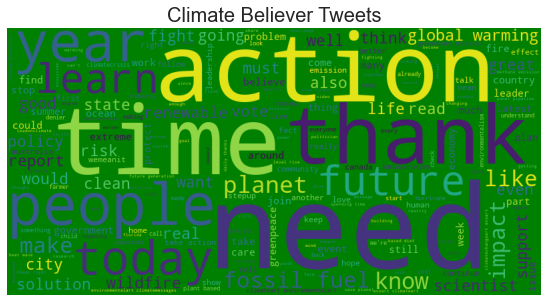

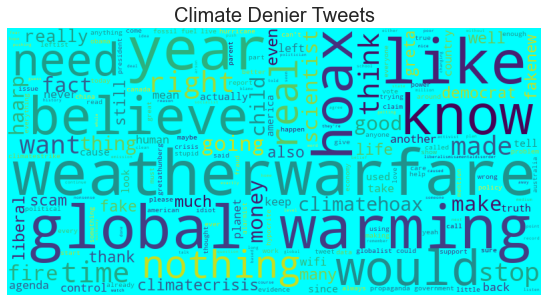

In [19]:
bel_cloud = WordCloud(width=800, height=400, min_word_length=4,
                      background_color='green', stopwords=stopwords_list + ['amp']).generate(bel_class)

den_cloud = WordCloud(width=800, height=400, min_word_length=4,
                      background_color='cyan', stopwords=stopwords_list + ['amp', 'people']).generate(den_class)

plt.figure(figsize=(8,4), facecolor=None)
plt.imshow(bel_cloud)
plt.axis('off')
plt.title('Climate Believer Tweets', fontdict={'fontsize': 20})
plt.tight_layout(pad=0)
plt.show()

plt.figure(figsize=(8,4), facecolor=None)
plt.imshow(den_cloud)
plt.axis('off')
plt.title('Climate Denier Tweets', fontdict={'fontsize': 20})
plt.tight_layout(pad=0)
plt.show()

From the visualizations, it looks like "thank", "need", "action, "time, "future are among the most common words in a tweet by someone expressing belief in climate change while "weatherwarfare", "global", "warming", and "hoax are among the most common words in a tweet by someone expressing their denial of climate change.

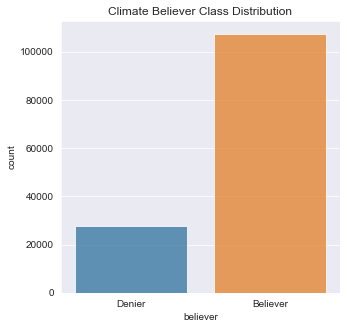

In [20]:
fig,ax = plt.subplots(figsize=(5,5))
sns.countplot(x = y, alpha = 0.76)
plt.xticks([0,1], ['Denier', 'Believer'])
plt.title("Climate Believer Class Distribution")
plt.show()

In [22]:
pickle_out = open('data/pickle_jar/X_y', 'wb')
pickle.dump((X,y), pickle_out)
pickle_out.close()

In [25]:
pickle_out = open('data/pickle_jar/all_stops', 'wb')
pickle.dump(stopwords_list, pickle_out)
pickle_out.close()